# Lorenz
Sam Hocking

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import json
import pandas as pd
import warnings
import sys

from NVAR import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)

In [2]:
tf = 100

lor_rk4 = np.loadtxt(f'./datasets/py-lorenz-scaled_RK4_{tf}.csv', delimiter=",", dtype='float64')
lor_rk4_noisy = np.loadtxt(f'./datasets/py-lorenz-scaled_RK4_noisy_{tf}.csv', delimiter=",", dtype='float64')
lor_rk23 = np.loadtxt(f'./datasets/py-lorenz-scaled_RK23_{tf}.csv', delimiter=",", dtype='float64')
lor_rk45 = np.loadtxt(f'./datasets/py-lorenz-scaled_RK45_{tf}.csv', delimiter=",", dtype='float64')
lor_dop853 = np.loadtxt(f'./datasets/py-lorenz-scaled_DOP853_{tf}.csv', delimiter=",", dtype='float64')
lor_radau = np.loadtxt(f'./datasets/py-lorenz-scaled_Radau_{tf}.csv', delimiter=",", dtype='float64')
lor_bdf = np.loadtxt(f'./datasets/py-lorenz-scaled_BDF_{tf}.csv', delimiter=",", dtype='float64')
lor_lsoda = np.loadtxt(f'./datasets/py-lorenz-scaled_LSODA_{tf}.csv', delimiter=",", dtype='float64')

In [3]:
lor_rk4_data = lor_rk4[:,1:]
lor_rk4_target = lor_rk4[1:,1:]
lor_rk23_data = lor_rk23[:,1:]
lor_rk23_target = lor_rk23[1:,1:]
lor_rk45_data = lor_rk45[:,1:]
lor_rk45_target = lor_rk45[1:,1:]
lor_dop853_data = lor_dop853[:,1:]
lor_dop853_target = lor_dop853[1:,1:]
lor_radau_data = lor_radau[:,1:]
lor_radau_target = lor_radau[1:,1:]
lor_bdf_data = lor_bdf[:,1:]
lor_bdf_target = lor_bdf[1:,1:]
lor_lsoda_data = lor_lsoda[:,1:]
lor_lsoda_target = lor_lsoda[1:,1:]

data_arr = [
    lor_rk4_data,
    lor_rk23_data,
    lor_rk45_data,
    lor_dop853_data,
    lor_radau_data,
    lor_bdf_data,
    lor_lsoda_data
]

target_arr = [
    lor_rk4_target,
    lor_rk23_target,
    lor_rk45_target,
    lor_dop853_target,
    lor_radau_target,
    lor_bdf_target,
    lor_lsoda_target
]

Cross-correlation function, between model $p$ and model $q$. The vector $\mathbf{x_t^p}$ denotes the state variable coordinates of model $p$ at time $t$.

$$R_{pq} = \frac{1}{N} \sum_{n=1}^{N} \frac{\mathbf{x_{n \Delta t}^{p}}}{\lVert \mathbf{x_{n \Delta t}^{p}}\rVert}\cdot\frac{\mathbf{x_{n \Delta t}^{q}}}{\lVert \mathbf{x_{n \Delta t}^{q}}\rVert}$$

In [4]:
corr_matrix = np.zeros((7,7))
ictr = 0
for x in data_arr:
    corr_vector = np.zeros((7,))
    jctr = 0
    for y in data_arr:
        corr_arr = np.array([(x[i,:]/np.linalg.norm(x[i,:])).dot(y[i,:]/np.linalg.norm(y[i,:])) for i in range(len(x))])
        corr = corr_arr.sum()/len(corr_arr)
        corr_vector[jctr] = corr
        jctr += 1
    corr_matrix[ictr,:] = corr_vector
    ictr += 1
corr_matrix

array([[1.        , 0.73521539, 0.76187413, 0.71937718, 0.74030407, 0.70383635, 0.74008424],
       [0.73521539, 1.        , 0.74624953, 0.74670396, 0.76856958, 0.73737532, 0.73593749],
       [0.76187413, 0.74624953, 1.        , 0.75358086, 0.76252908, 0.73952277, 0.73851089],
       [0.71937718, 0.74670396, 0.75358086, 1.        , 0.75844312, 0.74055574, 0.70900819],
       [0.74030407, 0.76856958, 0.76252908, 0.75844312, 1.        , 0.7268386 , 0.73431222],
       [0.70383635, 0.73737532, 0.73952277, 0.74055574, 0.7268386 , 1.        , 0.71807234],
       [0.74008424, 0.73593749, 0.73851089, 0.70900819, 0.73431222, 0.71807234, 1.        ]])

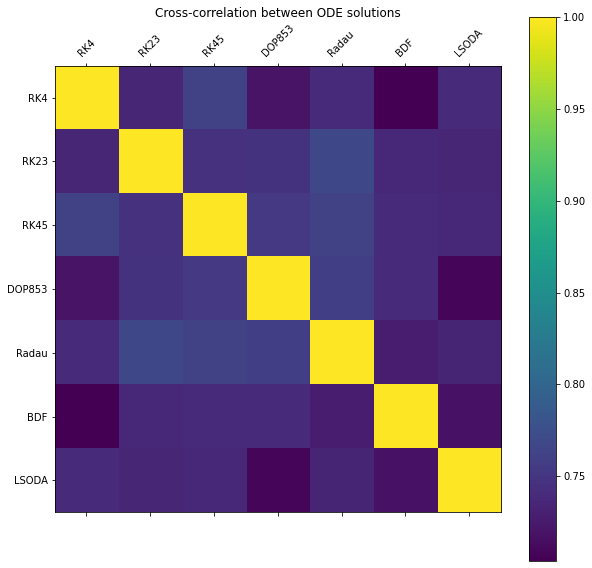

In [5]:
labels = ['RK4','RK23','RK45','DOP853','Radau','BDF','LSODA']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_matrix, interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(len(labels))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.title('Cross-correlation between ODE solutions')
plt.show()

In [6]:
k = 4
s = 6
reg = 1e-6

train_start=500
train_end=8000
test_start=train_end
test_end=10000

train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

lor_rk4_nvar_model = NVARModel(k, s, reg)
lor_rk4_nvar_model.train(data_arr[0], target_arr[0], train_indices)

lor_rk23_nvar_model = NVARModel(k, s, reg)
lor_rk23_nvar_model.train(data_arr[1], target_arr[1], train_indices)

lor_rk45_nvar_model = NVARModel(k, s, reg)
lor_rk45_nvar_model.train(data_arr[2], target_arr[2], train_indices)

lor_dop853_nvar_model = NVARModel(k, s, reg)
lor_dop853_nvar_model.train(data_arr[3], target_arr[3], train_indices)

lor_radau_nvar_model = NVARModel(k, s, reg)
lor_radau_nvar_model.train(data_arr[4], target_arr[4], train_indices)

lor_bdf_nvar_model = NVARModel(k, s, reg)
lor_bdf_nvar_model.train(data_arr[5], target_arr[5], train_indices)

lor_lsoda_nvar_model = NVARModel(k, s, reg)
lor_lsoda_nvar_model.train(data_arr[6], target_arr[6], train_indices)

model_arr = [
    lor_rk4_nvar_model,
    lor_rk23_nvar_model,
    lor_rk45_nvar_model,
    lor_dop853_nvar_model,
    lor_radau_nvar_model,
    lor_bdf_nvar_model,
    lor_lsoda_nvar_model,
]

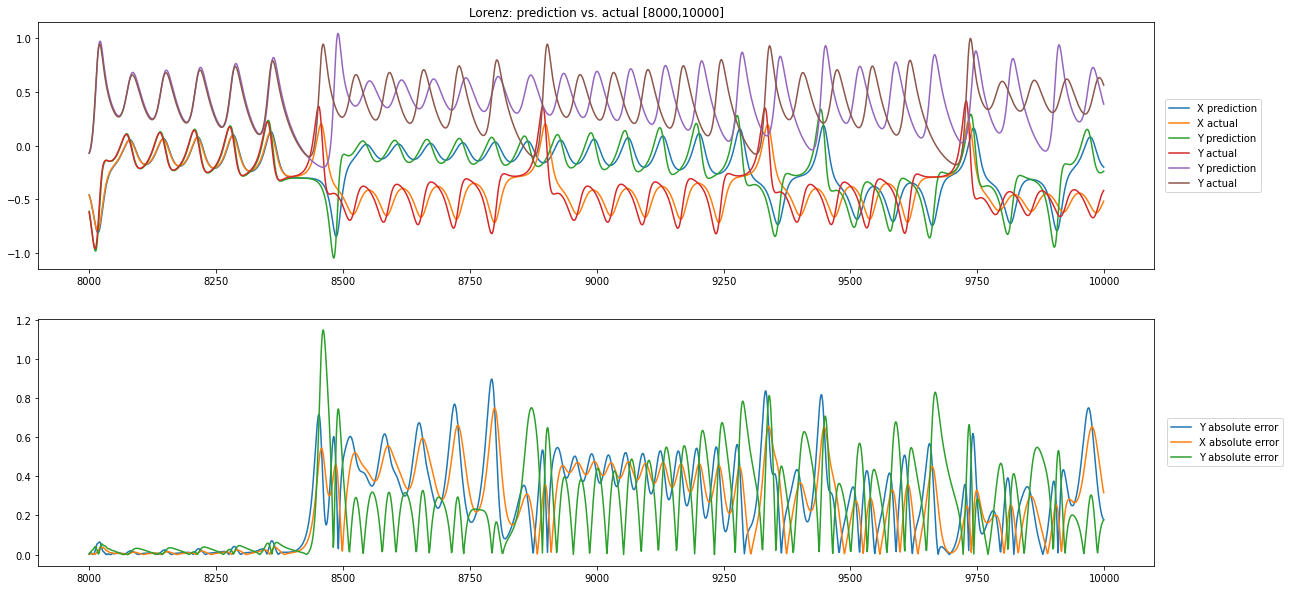

In [7]:
test_data_idx = 0
model_idx = 1

data = data_arr[test_data_idx]
recursive_out_arr = [x.recursive_predict(data, train_start, test_start, test_end-test_start) for x in model_arr]

recursive_out = recursive_out_arr[model_idx]
data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 10))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [8]:
mappable = plt.cm.ScalarMappable(cmap='gray')
mappable.set_array([0,1])   

In [9]:
n = len(data_arr)
all_rmse_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        all_rmse_matrix[i,j] = RMSE(data_arr[i][train_start:test_end], data_arr[j][train_start:test_end])
all_rmse_matrix

array([[0.        , 0.57366677, 0.57398895, 0.59325998, 0.55516842, 0.60816969, 0.58688814],
       [0.57366677, 0.        , 0.59135831, 0.59276573, 0.57105727, 0.5911748 , 0.60415545],
       [0.57398895, 0.59135831, 0.        , 0.5922401 , 0.57528157, 0.57836279, 0.6224076 ],
       [0.59325998, 0.59276573, 0.5922401 , 0.        , 0.57245768, 0.58015502, 0.63900746],
       [0.55516842, 0.57105727, 0.57528157, 0.57245768, 0.        , 0.58278555, 0.5929667 ],
       [0.60816969, 0.5911748 , 0.57836279, 0.58015502, 0.58278555, 0.        , 0.61824844],
       [0.58688814, 0.60415545, 0.6224076 , 0.63900746, 0.5929667 , 0.61824844, 0.        ]])

In [10]:
n = len(data_arr)
train_rmse_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        train_rmse_matrix[i,j] = RMSE(data_arr[i][train_start:train_end], data_arr[j][train_start:train_end])
train_rmse_matrix

array([[0.        , 0.56310245, 0.55193548, 0.60391473, 0.57571302, 0.59624313, 0.59957296],
       [0.56310245, 0.        , 0.58970244, 0.59585286, 0.5784752 , 0.57949897, 0.60024054],
       [0.55193548, 0.58970244, 0.        , 0.57429387, 0.56227127, 0.5654996 , 0.63256819],
       [0.60391473, 0.59585286, 0.57429387, 0.        , 0.57756689, 0.5646796 , 0.62906559],
       [0.57571302, 0.5784752 , 0.56227127, 0.57756689, 0.        , 0.57393694, 0.59250503],
       [0.59624313, 0.57949897, 0.5654996 , 0.5646796 , 0.57393694, 0.        , 0.62096963],
       [0.59957296, 0.60024054, 0.63256819, 0.62906559, 0.59250503, 0.62096963, 0.        ]])

In [11]:
n = len(data_arr)
test_rmse_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        test_rmse_matrix[i,j] = RMSE(data_arr[i][test_start:test_end], data_arr[j][test_start:test_end])
test_rmse_matrix

array([[0.        , 0.61166006, 0.65005988, 0.55147432, 0.47019815, 0.65095106, 0.53665634],
       [0.61166006, 0.        , 0.59752696, 0.58104291, 0.54233716, 0.63304411, 0.61861574],
       [0.65005988, 0.59752696, 0.        , 0.65517488, 0.62164986, 0.62424354, 0.58272969],
       [0.55147432, 0.58104291, 0.65517488, 0.        , 0.55287779, 0.63483687, 0.67498656],
       [0.47019815, 0.54233716, 0.62164986, 0.55287779, 0.        , 0.61483471, 0.59469478],
       [0.65095106, 0.63304411, 0.62424354, 0.63483687, 0.61483471, 0.        , 0.60793548],
       [0.53665634, 0.61861574, 0.58272969, 0.67498656, 0.59469478, 0.60793548, 0.        ]])

In [12]:
n = len(data_arr)
rmse_matrix = np.zeros((n,n))
# loop through models
for i in range(n):
    # loop through predictive data source
    for j in range(n):
        rmse_matrix[i,j] = RMSE(target_arr[j][test_start:], model_arr[i].recursive_predict(data_arr[j], train_start, train_end, test_end-test_start))
rmse_matrix

array([[0.33485713, 0.60205342, 0.54985273, 0.55933913, 0.49716993, 0.52053682, 0.55151885],
       [0.57617905, 0.3724266 , 0.57460987, 0.50879109, 0.55643583, 0.50298114, 0.54714073],
       [0.57132187, 0.63592615, 0.42631399, 0.45956817, 0.51142841, 0.6136157 , 0.56608243],
       [0.55119227, 0.5372782 , 0.46211785, 0.39715373, 0.55439024, 0.58379425, 0.47678796],
       [0.53464069, 0.57442495, 0.48754157, 0.54460742, 0.42708367, 0.57186751, 0.55530705],
       [0.46067124, 0.50189417, 0.57274785, 0.49355454, 0.54346966, 0.46363054, 0.57617261],
       [0.56814696, 0.6127706 , 0.497388  , 0.57641317, 0.51468391, 0.57744832, 0.44258087]])

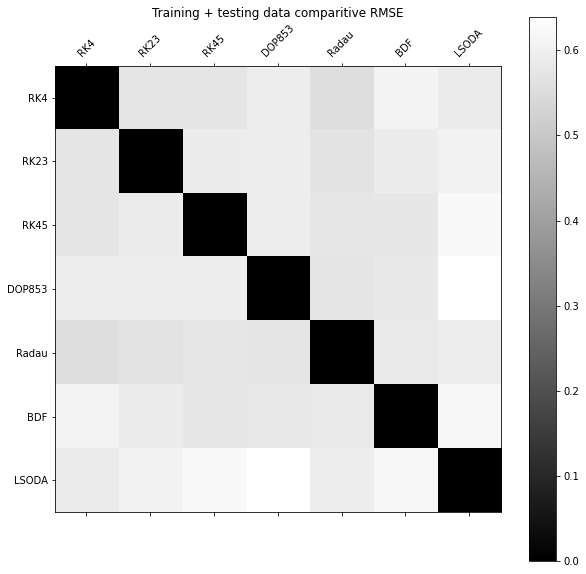

In [13]:
labels = ['RK4','RK23','RK45','DOP853','Radau','BDF','LSODA']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(all_rmse_matrix, cmap='gray', interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(len(labels))
ax.xaxis.set_label_position('top') 
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.title('Training + testing data comparitive RMSE')
plt.show()

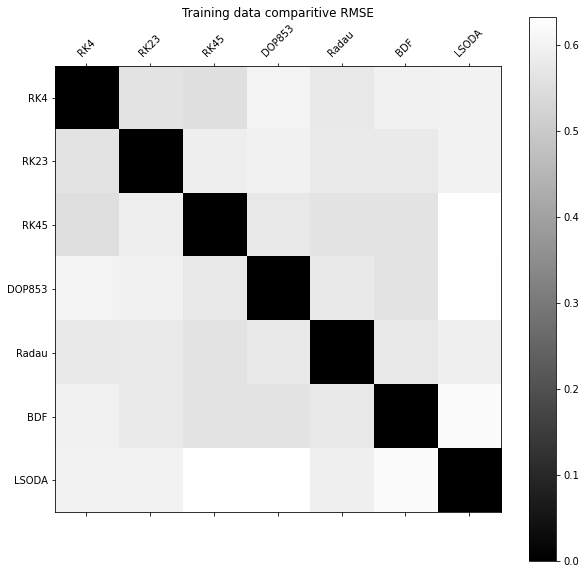

In [14]:
labels = ['RK4','RK23','RK45','DOP853','Radau','BDF','LSODA']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(train_rmse_matrix, cmap='gray', interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(len(labels))
ax.xaxis.set_label_position('top') 
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.title('Training data comparitive RMSE')
plt.show()

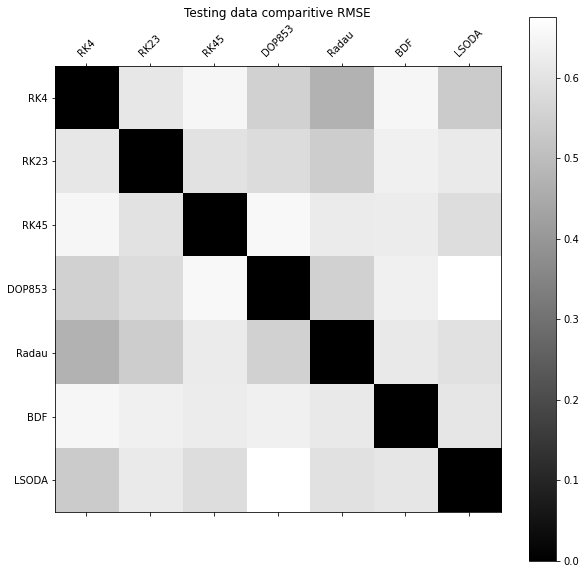

In [15]:
labels = ['RK4','RK23','RK45','DOP853','Radau','BDF','LSODA']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(test_rmse_matrix, cmap='gray', interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(len(labels))
ax.xaxis.set_label_position('top') 
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.title('Testing data comparitive RMSE')
plt.show()

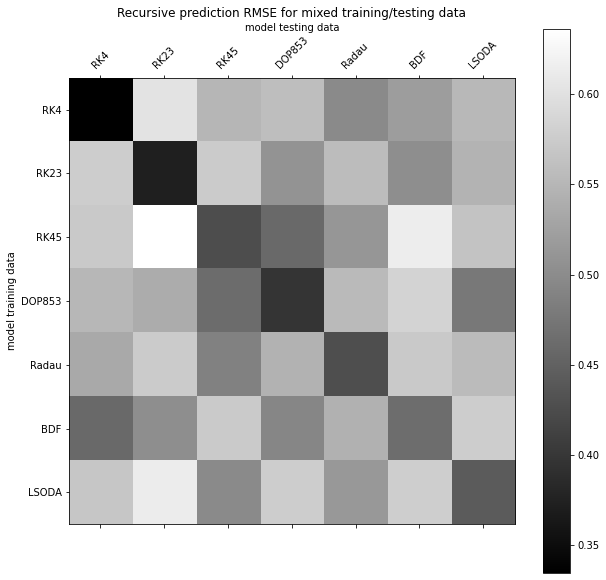

In [16]:
labels = ['RK4','RK23','RK45','DOP853','Radau','BDF','LSODA']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(rmse_matrix, cmap='gray', interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(len(labels))
ax.set_xlabel('model testing data')
ax.set_ylabel('model training data')
ax.xaxis.set_label_position('top') 
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.title('Recursive prediction RMSE for mixed training/testing data')
plt.show()

Introduce Noisy Data

In [17]:
lor_rk4_noisy_data = lor_rk4_noisy[:,1:]
lor_rk4_noisy_target = lor_rk4_noisy[1:,1:]

lor_rk4_noisy_nvar_model = NVARModel(k, s, reg)
lor_rk4_noisy_nvar_model.train(lor_rk4_noisy_data, lor_rk4_noisy_target, train_indices)

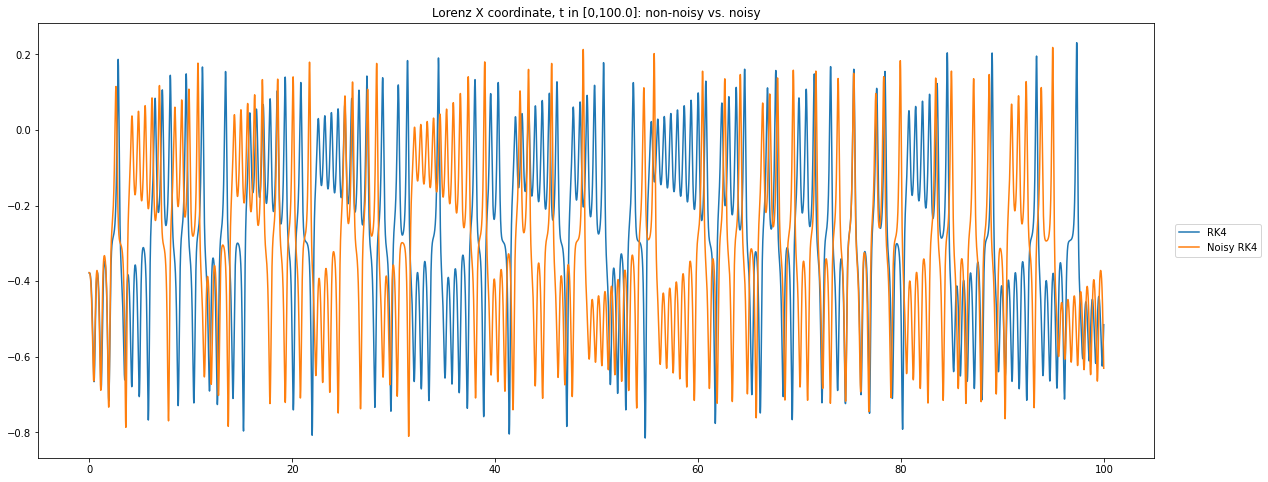

In [18]:
num_pts = 10000

tt = lor_rk4_noisy[:,0]

fig, axs = plt.subplots(1, figsize=(20, 8))
axs.plot(lor_rk4[:num_pts,0], lor_rk4[:num_pts,1], label="RK4")
axs.plot(lor_rk4_noisy[:num_pts,0], lor_rk4_noisy[:num_pts,1], label="Noisy RK4")
axs.legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs.set_title(f'Lorenz X coordinate, t in [0,{tt[num_pts]}]: non-noisy vs. noisy')
plt.show()

In [19]:
# cross-correlation
corr_arr = np.array([(lor_rk4_noisy_data[i,:]/np.linalg.norm(lor_rk4_noisy_data[i,:])).dot(lor_rk4_data[i,:]/np.linalg.norm(lor_rk4_data[i,:])) for i in range(len(x))])
corr = corr_arr.sum()/len(corr_arr)
corr

0.708203722198235

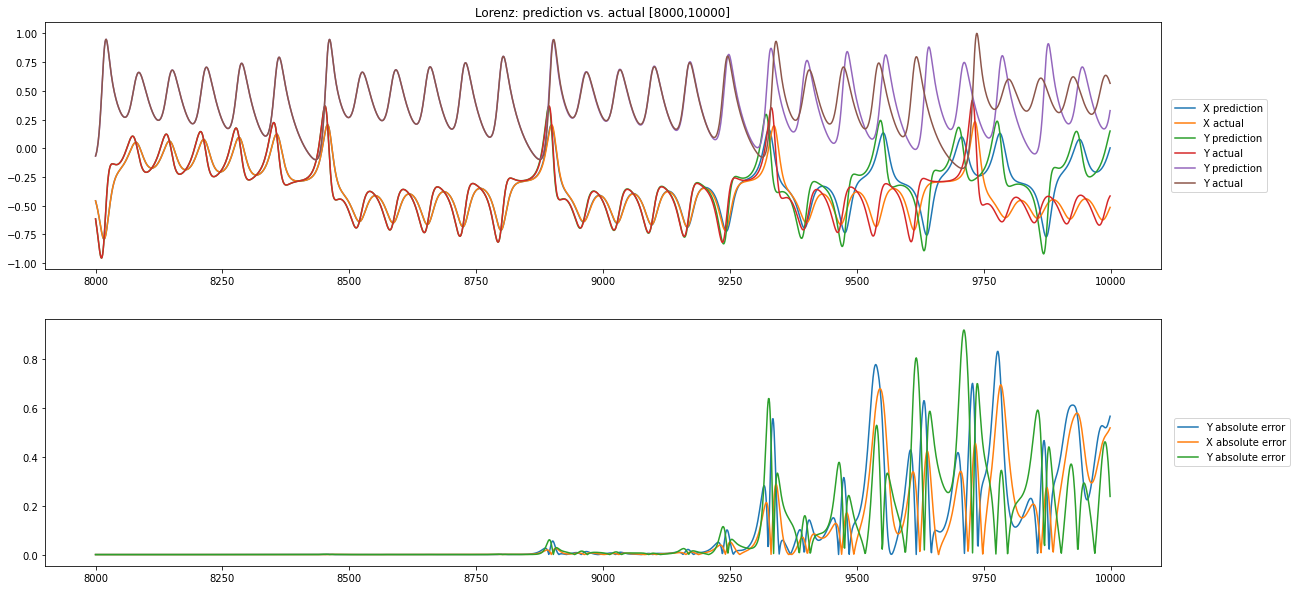

In [20]:
# train on non-noisy, predict non-noisy

recursive_out = lor_rk4_nvar_model.recursive_predict(lor_rk4_data, train_start, test_start, test_end-test_start)
data = lor_rk4_data
data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 10))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

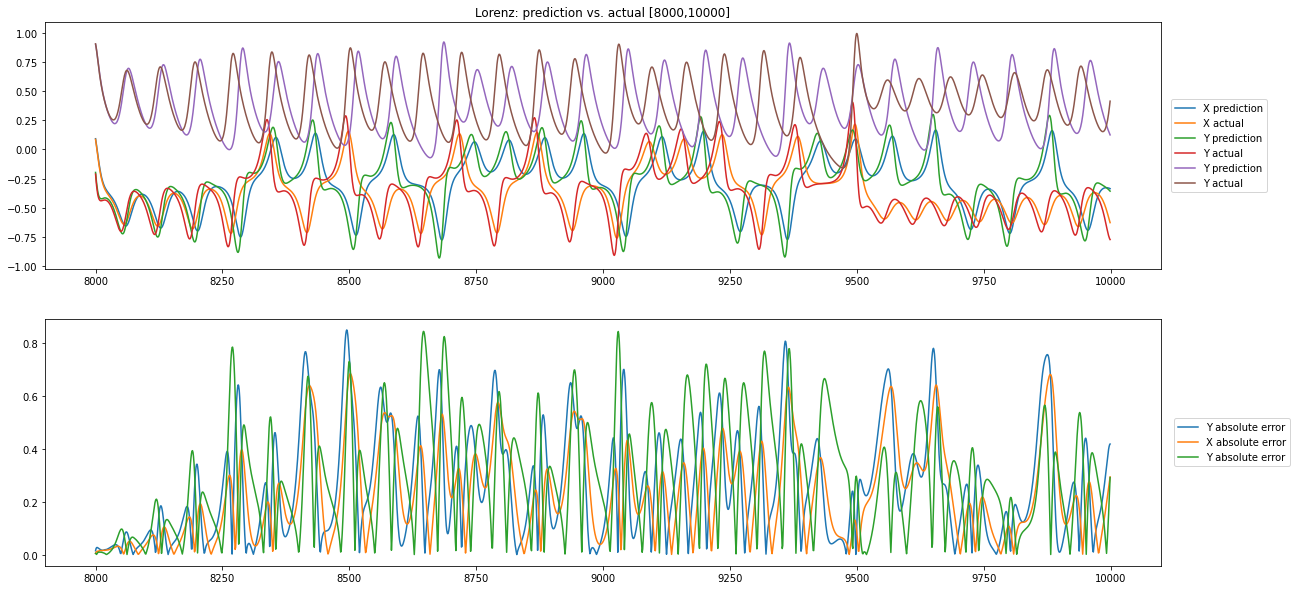

In [21]:
# train on non-noisy, predict noisy

recursive_out = lor_rk4_nvar_model.recursive_predict(lor_rk4_noisy_data, train_start, test_start, test_end-test_start)
data = lor_rk4_noisy_data
data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 10))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

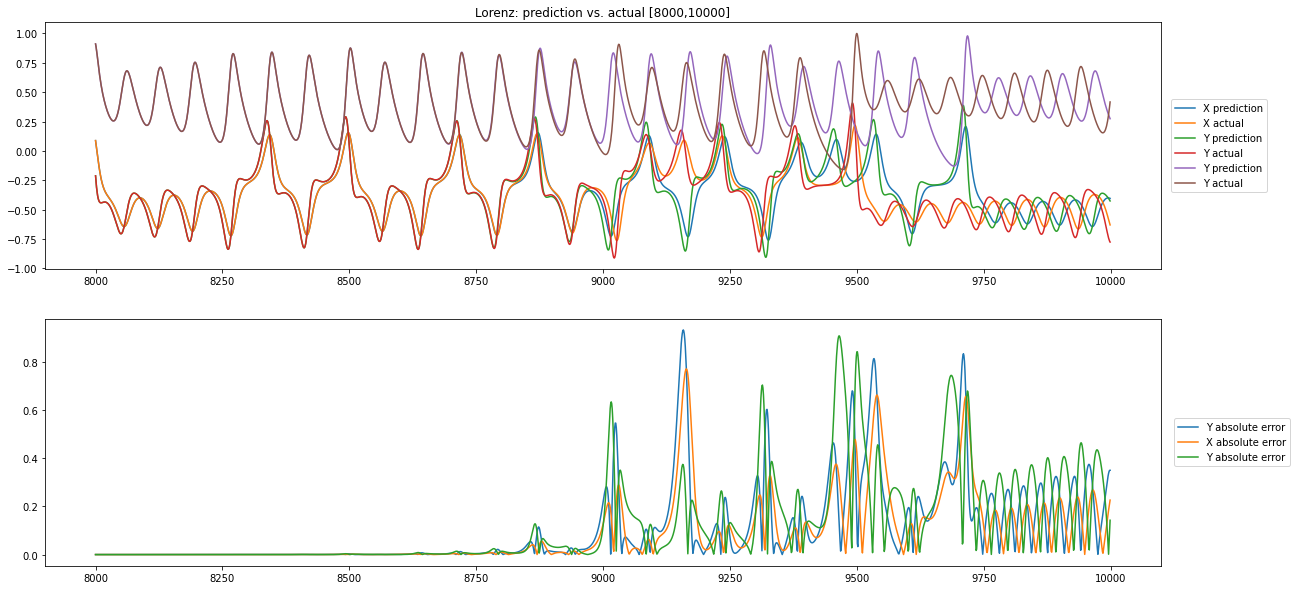

In [22]:
# train on noisy, predict noisy

recursive_out = lor_rk4_noisy_nvar_model.recursive_predict(lor_rk4_noisy_data, train_start, test_start, test_end-test_start)
data = lor_rk4_noisy_data
data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 10))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

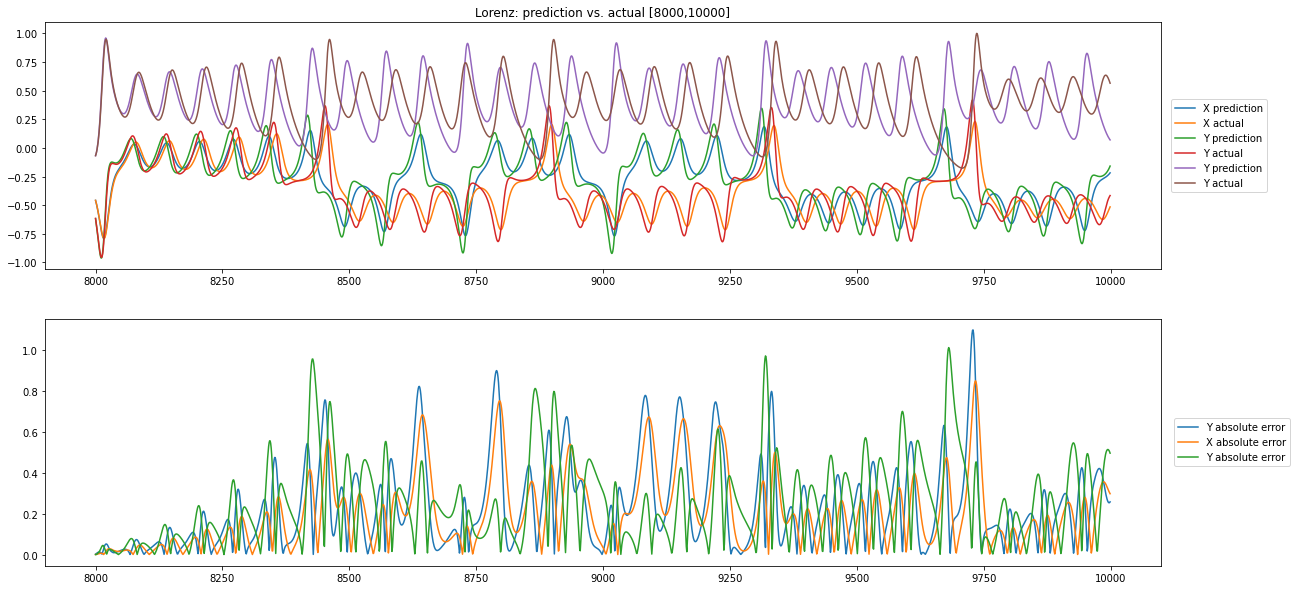

In [23]:
# train on noisy, predict non-noisy

recursive_out = lor_rk4_noisy_nvar_model.recursive_predict(lor_rk4_data, train_start, test_start, test_end-test_start)
data = lor_rk4_data
data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 10))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [24]:
d_arr = [lor_rk4_data, lor_rk4_noisy_data]
t_arr = [lor_rk4_target, lor_rk4_noisy_target]
m_arr = [lor_rk4_nvar_model, lor_rk4_noisy_nvar_model]
n = len(d_arr)

rmse_matrix_noise = np.zeros((n,n))
# loop through models
for i in range(n):
    # loop through predictive data source
    for j in range(n):
        rmse_matrix_noise[i,j] = RMSE(t_arr[j][test_start:], m_arr[i].recursive_predict(d_arr[j], train_start, train_end, test_end-test_start))
rmse_matrix_noise

array([[0.33485713, 0.56541572],
       [0.51737709, 0.34621944]])

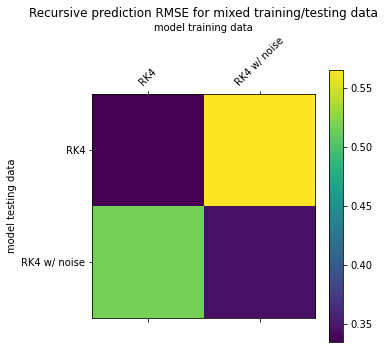

In [25]:
labels = ['RK4','RK4 w/ noise']

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(rmse_matrix_noise, interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(len(labels))
ax.set_xlabel('model training data')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('model testing data')
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.title('Recursive prediction RMSE for mixed training/testing data')
plt.show()